<a href="https://colab.research.google.com/github/lro99/fraud_classification/blob/main/Fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from imblearn.under_sampling import RandomUnderSampler
# from google.colab import drive

import tensorflow as tf
from tensorflow import keras

In [2]:
train = pd.read_parquet('/content/drive/MyDrive/Documents/Data Career/fraud_classification/train-00000-of-00002.parquet')
train.to_csv('fraud0.csv')

train1 = pd.read_parquet('/content/drive/MyDrive/Documents/Data Career/fraud_classification/train-00001-of-00002.parquet')
train1.to_csv('fraud1.csv')

In [3]:
train_df = pd.concat([train, train1], ignore_index=True)

# fraction = 0.55
# train_df = train_df_unsampled.sample(frac=fraction, random_state=42)

train_df.head()

,ssn,cc_num,first,last,gender,city,state,zip,city_pop,job,dob,acct_num,trans_num,trans_date,trans_time,unix_time,category,amt,is_fraud,merchant
0,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,c036244703adb9d5392f4027d9d4b38d,2021-07-31,02:30:01,1627678801,grocery_pos,337.54,1,fraud_Kovacek
1,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,42f000b0b3b0ef534e5b8ef9ec1db13a,2021-08-01,22:37:41,1627837661,personal_care,21.13,1,fraud_Bradtke
2,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,543037b1baf088961e58d00b705f4bcc,2021-08-01,23:02:09,1627839129,personal_care,22.61,1,fraud_Kozey-Kuhlman
3,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,00a4e08643edebf9277c2967676f6a26,2021-08-01,22:27:24,1627837044,health_fitness,17.32,1,fraud_Hills
4,367-85-9826,4361337605230458,Kristie,Davis,F,Chandler,OK,74834,7590,Chief Strategy Officer,1987-06-12,349734538563,492c4412815306718f686fc5b459a285,2021-12-02,02:28:51,1638392331,misc_pos,75.82,0,fraud_Kemmer-Buckridge


In [4]:
train_df.dtypes

,0
ssn,object
cc_num,int64
first,object
last,object
gender,object
city,object
state,object
zip,int64
city_pop,int64
job,object


Class Label Imbalance

In [5]:
neg, pos = train_df['is_fraud'].value_counts()
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 2646694
    Positive: 9422 (0.36% of total)



In [6]:
X = train_df.drop('is_fraud', axis=1)
y = train_df['is_fraud']
print(X.shape, y.shape)

(2646694, 19) (2646694,)


In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)

(2117355, 19) (529339, 19)


Data preprocessing (outside model)

In [10]:
# encoding

# ssn: drop dash, convert to int
# first: drop
# last: drop
# gender: onehot encode
# city & state: concatenate
# job: label encode
# dob: drop dash, convert to int
# transnum: potentially drop
# transdate: drop
# transtime: drop
# category: label encode
# merchant: label encode

In [8]:
# conversions
train_df['ssn'] = train_df['ssn'].str.replace('-', '').astype(int)
train_df['dob'] = train_df['dob'].str.replace('-', '').astype(int)

train_df['location'] = train_df['city'] + ', ' + train_df['state']

# onehot encode (gender)
onehot = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
onehot.fit(train_df[['gender']])

feature_names = onehot.get_feature_names_out(['gender'])
gender_encoded = pd.DataFrame(onehot.transform(train_df[['gender']]), columns=feature_names)

# label encode (job, category, merchant)
encode_df = train_df[['job', 'category', 'merchant', 'location']]
encoder = LabelEncoder()
for col in encode_df.columns:
    encode_df[col] = encoder.fit_transform(encode_df[col])

# drop unneeded columns
train_df = train_df.drop(['job', 'category', 'merchant', 'first', 'last', 'trans_num', 'trans_date', 'trans_time', 'city', 'state', 'gender', 'location'], axis=1)
train_df.head()


<ipython-input-8-2f29263f5388>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encode_df[col] = encoder.fit_transform(encode_df[col])
<ipython-input-8-2f29263f5388>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  encode_df[col] = encoder.fit_transform(encode_df[col])
<ipython-input-8-2f29263f5388>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

,ssn,cc_num,zip,city_pop,dob,acct_num,unix_time,amt,is_fraud
0,367859826,4361337605230458,74834,7590,19870612,349734538563,1627678801,337.54,1
1,367859826,4361337605230458,74834,7590,19870612,349734538563,1627837661,21.13,1
2,367859826,4361337605230458,74834,7590,19870612,349734538563,1627839129,22.61,1
3,367859826,4361337605230458,74834,7590,19870612,349734538563,1627837044,17.32,1
4,367859826,4361337605230458,74834,7590,19870612,349734538563,1638392331,75.82,0


In [9]:
final_df = pd.concat([train_df, gender_encoded, encode_df], axis=1)
final_df.head()

,ssn,cc_num,zip,city_pop,dob,acct_num,unix_time,amt,is_fraud,gender_F,gender_M,job,category,merchant,location
0,367859826,4361337605230458,74834,7590,19870612,349734538563,1627678801,337.54,1,1.0,0.0,72,4,317,116
1,367859826,4361337605230458,74834,7590,19870612,349734538563,1627837661,21.13,1,1.0,0.0,72,10,67,116
2,367859826,4361337605230458,74834,7590,19870612,349734538563,1627839129,22.61,1,1.0,0.0,72,10,320,116
3,367859826,4361337605230458,74834,7590,19870612,349734538563,1627837044,17.32,1,1.0,0.0,72,5,238,116
4,367859826,4361337605230458,74834,7590,19870612,349734538563,1638392331,75.82,0,1.0,0.0,72,9,283,116


In [10]:
train_df, test_df = train_test_split(final_df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_labels = np.array(train_df.pop('is_fraud')).reshape(-1,1)
val_labels = np.array(val_df.pop('is_fraud')).reshape(-1,1)
test_labels = np.array(test_df.pop('is_fraud')).reshape(-1,1)

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

print(train_labels.shape, val_labels.shape, test_labels.shape)

print(f'Average class probability in train set: {train_labels.mean():.3f}')
print(f'Average class probability in val set: {val_labels.mean():.3f}')
print(f'Average class probability in test set: {test_labels.mean():.3f}')

(1693884, 1) (423471, 1) (529339, 1)
Average class probability in train set: 0.004
Average class probability in val set: 0.004
Average class probability in test set: 0.004


In [11]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (1693884, 1)
Validation labels shape: (423471, 1)
Test labels shape: (529339, 1)
Training features shape: (1693884, 14)
Validation features shape: (423471, 14)
Test features shape: (529339, 14)


## Define model

In [12]:
METRICS = [
      keras.metrics.BinaryCrossentropy(name='cross entropy'),  # same as model's loss
      keras.metrics.MeanSquaredError(name='Brier score'),
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

## Baseline Model

In [13]:
EPOCHS = 100
BATCH_SIZE = 2048

def early_stopping():
 return tf.keras.callbacks.EarlyStopping(
    monitor='val_prc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [14]:
model = make_model()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 257 (1.00 KB)

 Trainable params: 257 (1.00 KB)

 Non-trainable params: 0 (0.00 B)

Test run baseline model

In [15]:
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step


array([[0.30115286],
       [0.41508543],
       [0.36576003],
       [0.29583853],
       [0.26659536],
       [0.31388226],
       [0.26530376],
       [0.36185798],
       [0.38860303],
       [0.2413745 ]], dtype=float32)

Set correct initial bias

In [16]:
initial_bias = np.log([pos/neg])
initial_bias

array([-5.63445295])

Baseline with initial bias

In [17]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


array([[0.00371529],
       [0.00395947],
       [0.00650984],
       [0.00344358],
       [0.00842436],
       [0.00667642],
       [0.00370054],
       [0.00089348],
       [0.00340915],
       [0.00546494]], dtype=float32)

In [18]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0227


Saving initial weights to temp file

In [19]:
import tempfile

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial.weights.h5')
model.save_weights(initial_weights)


##Bias vs Non-Bias Comparison

In [20]:
# no initial bias

model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    verbose=0
)

Epoch 20: early stopping
Restoring model weights from the end of the best epoch: 10.


In [23]:
# model with initial bias

model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    verbose=0
)

Restoring model weights from the end of the best epoch: 15.


In [24]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

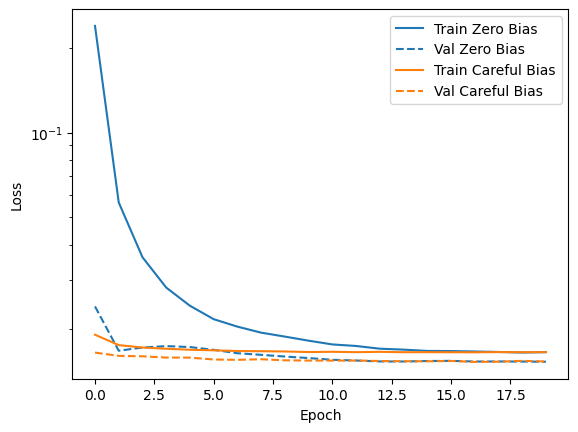

In [25]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

## Train Model

In [26]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels))

Epoch 1/100
828/828 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - Brier score: 0.0033 - accuracy: 0.9964 - auc: 0.8146 - cross entropy: 0.0183 - fn: 4437.2451 - fp: 198.6972 - loss: 0.0208 - prc: 0.1409 - precision: 0.4286 - recall: 0.0187 - tn: 1268649.6250 - tp: 98.5066 - val_Brier score: 0.0032 - val_accuracy: 0.9965 - val_auc: 0.8370 - val_cross entropy: 0.0165 - val_fn: 1497.0000 - val_fp: 0.0000e+00 - val_loss: 0.0165 - val_prc: 0.2227 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_tn: 421974.0000 - val_tp: 0.0000e+00
Epoch 2/100
828/828 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - Brier score: 0.0034 - accuracy: 0.9962 - auc: 0.8196 - cross entropy: 0.0179 - fn: 2834.6562 - fp: 362.4053 - loss: 0.0179 - prc: 0.1454 - precision: 0.3482 - recall: 0.0640 - tn: 846515.0000 - tp: 200.9650 - val_Brier score: 0.0031 - val_accuracy: 0.9965 - val_auc: 0.8464 - val_cross entropy: 0.0161 - val_fn: 1497.0000 - val_fp: 0.0000e+00 - val_loss: 0.0161 - val_prc: 0.2314 - val_precision: 0.0000e+00 - val_

In [27]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

828/828 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [28]:
def plot_cm(labels, predictions, threshold=0.5):
  cm = confusion_matrix(labels, predictions > threshold)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title("Confusion matrix @{:.2f}".format(threshold))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

loss :  0.015705397352576256
compile_metrics :  0.015705397352576256



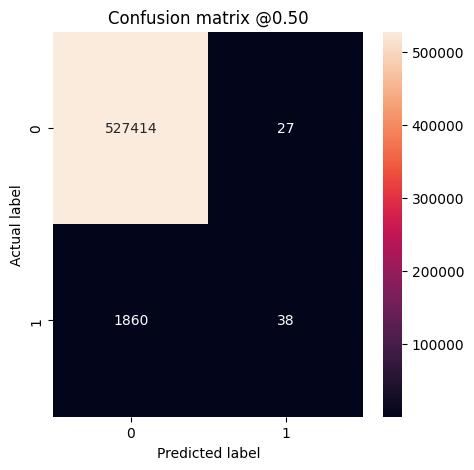

In [29]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

F1 Score

In [31]:
f1 = f1_score(test_labels, test_predictions_baseline > 0.5)
print(f'F1 Score: {f1}')

F1 Score: 0.03871625063678044


## Class Weights

In [32]:
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 140.45


## Train model with class weights

In [33]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping()],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
828/828 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - Brier score: 0.0219 - accuracy: 0.9725 - auc: 0.7669 - cross entropy: 0.0863 - fn: 3876.2773 - fp: 44189.9062 - loss: 1.4106 - prc: 0.0586 - precision: 0.1103 - recall: 0.1754 - tn: 1330131.5000 - tp: 1054.3704 - val_Brier score: 0.0472 - val_accuracy: 0.9663 - val_auc: 0.8590 - val_cross entropy: 0.2345 - val_fn: 451.0000 - val_fp: 13812.0000 - val_loss: 0.2345 - val_prc: 0.1460 - val_precision: 0.0704 - val_recall: 0.6987 - val_tn: 408162.0000 - val_tp: 1046.0000
Epoch 2/100
828/828 ━━━━━━━━━━━━━━━━━━━━ 16s 13ms/step - Brier score: 0.1040 - accuracy: 0.8637 - auc: 0.8161 - cross entropy: 0.3849 - fn: 1002.3052 - fp: 112335.5234 - loss: 0.6049 - prc: 0.0878 - precision: 0.0172 - recall: 0.6661 - tn: 734570.7500 - tp: 2004.4500 - val_Brier score: 0.0490 - val_accuracy: 0.9631 - val_auc: 0.8556 - val_cross entropy: 0.2573 - val_fn: 356.0000 - val_fp: 15260.0000 - val_loss: 0.2573 - val_prc: 0.1289 - val_precision: 0.0696 - val_recal

In [34]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

## Comparing metric history - Baseline versus Weighted

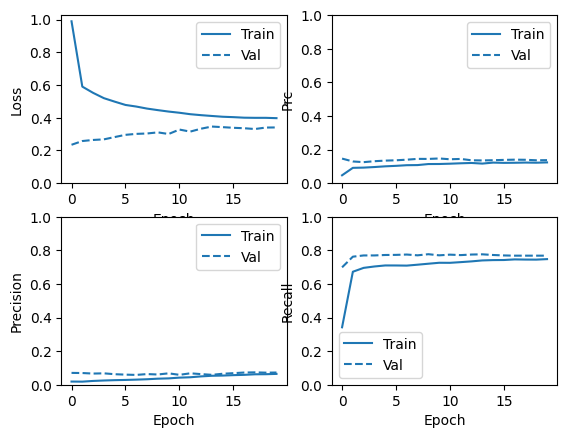

In [35]:
plot_metrics(weighted_history)

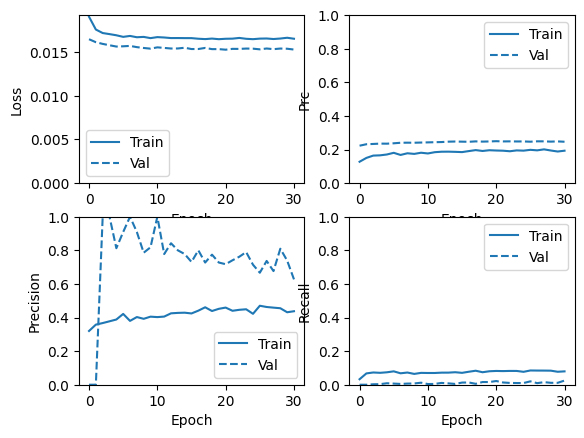

In [36]:
plot_metrics(baseline_history)

## Evaluate metrics

In [37]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

828/828 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
259/259 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


loss :  0.30046841502189636
compile_metrics :  0.30046841502189636



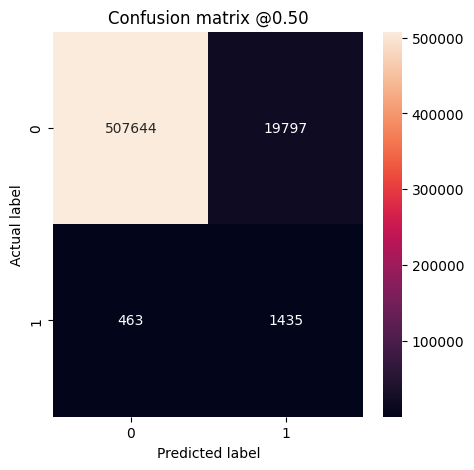

In [38]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [39]:
f1 = f1_score(test_labels, test_predictions_weighted > 0.5)
print(f'F1 Score: {f1}')

F1 Score: 0.12408127972330307


In [ ]:
# saving the file
import pickle
file_path = '/content/drive/MyDrive/Documents/Data Career/fraud_classification/fraud_class_tf.pkl'

with open(file_path, "wb") as f:
    pickle.dump(model, f)